A unit Poisson counting process, $Y(t)$, is a integer-valued stochastic process that increases by one at random times. These times correspond to samples from an exponential distribution with parameter $\lambda=1$.

A simple code to simulate $Y(t)$ is:

In [50]:
using Plots, Random, LaTeXStrings
pyplot()

Plots.PyPlotBackend()

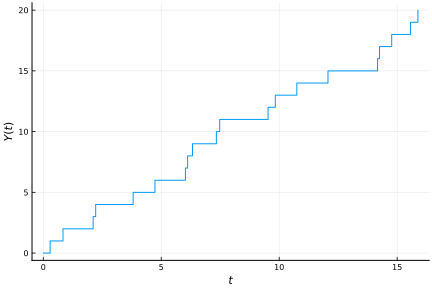

In [51]:
nsteps = 20
Y = zeros(Int, nsteps + 1)
T = zeros(Float64, nsteps + 1)
for i = 1:nsteps
    T[i+1] = T[i] + randexp()
    Y[i+1] = Y[i] + 1
end
plot(T,Y,linetype=:steppost, xlabel=L"t", ylabel=L"Y(t)", fmt=:svg, legend=false)

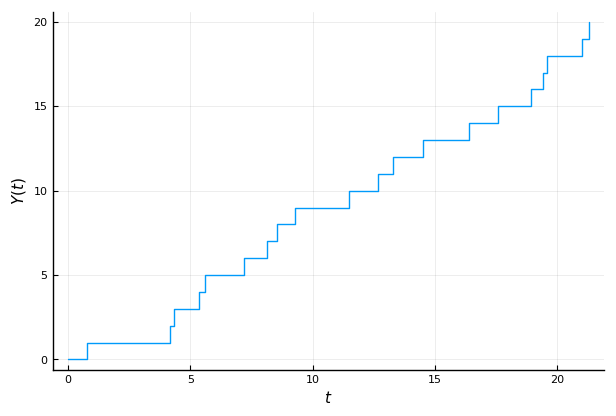

In [37]:
plot(T,Y,linetype=:steppost, xlabel=L"t", ylabel=L"Y(t)", fmt=:pdf, legend=false)
fname = string(pwd(),"/figs/unitpoisson.pdf")
savefig(fname)

Stochastic chemical kinetics is a more *microscopic* physical model for chemical reactions that deterministic reaction-rate ODEs. Here we interpret rate laws as giving the probability per time a reaction occurs, resulting in a compound Poisson counting process for the state of the system. For example, consider the reaction system:

In [13]:
using DiffEqBiological, Latexify
rn = @reaction_network begin
   (k₊,k₋), A + B ↔ C
    α, 0 --> C
    β, A --> 0
    γ, B --> 0
end k₊ k₋ α β γ
latexify(rn; env=:chemical)

L"\begin{align}
\require{mhchem}
\ce{ A + B &<=>[k_{+}][k_{-}] C}\\
\ce{ \varnothing &->[\alpha] C}\\
\ce{ A &->[\beta] \varnothing}\\
\ce{ B &->[\gamma] \varnothing}
\end{align}
"

The ODE version of the model is:

In [14]:
latexify(rn)

L"\begin{align}
\frac{dA}{dt} =&  - k_+ \cdot A \cdot B + k_- \cdot C - \beta \cdot A \\
\frac{dB}{dt} =&  - k_+ \cdot A \cdot B + k_- \cdot C - \gamma \cdot B \\
\frac{dC}{dt} =& k_+ \cdot A \cdot B - k_- \cdot C + \alpha \\
\end{align}
"

If we integrate these equations we obtain the integral equation version of the ODEs:

\begin{align*}
A(t) &= A(0) - k_{+} \int_0^t A(s) B(s) \, ds +  k_{-} \int_0^t C(s)  \, ds  - \beta \int_0^t A(s) \, ds, \\
B(t) &= B(0) - k_{+} \int_0^t A(s) B(s) \, ds +  k_{-} \int_0^t C(s)  \, ds  - \gamma \int_0^t B(s) \, ds, \\ 
C(t) &= C(0) + k_{+} \int_0^t A(s) B(s) \, ds -  k_{-} \int_0^t C(s)  \, ds  + \alpha \int_0^t C(s) \, ds.
\end{align*}

While the stochastic chemical kinetics jump process model is:

\begin{align*}
A(t) &= A(0) - Y_1 \left( k_{+} \int_0^t A(s) B(s) \, ds \right) + Y_2 \left( k_{-} \int_0^t C(s)  \, ds \right) - Y_4 \left( \beta \int_0^t A(s) \, ds \right), \\
B(t) &= B(0) - Y_1 \left( k_{+} \int_0^t A(s) B(s) \, ds \right) + Y_2 \left( k_{-} \int_0^t C(s)  \, ds \right) - Y_5 \left( \gamma \int_0^t B(s) \, ds \right), \\ 
C(t) &= C(0) + Y_1 \left( k_{+} \int_0^t A(s) B(s) \, ds \right) - Y_2 \left( k_{-} \int_0^t C(s)  \, ds \right) + Y_3 \left( \alpha \int_0^t C(s) \, ds \right).
\end{align*}

Notice, each reaction has an associated Poisson counting process that keeps track of how many times it occurs!

How do the solutions compare?

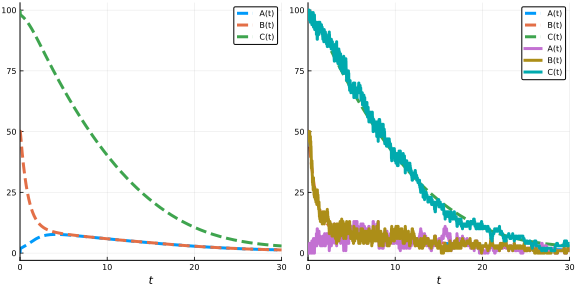

In [48]:
using OrdinaryDiffEq
u0 = [0., 50., 100.]
p  = [1., 1., 1., 1., 1.]
tspan = (0.,30.)
oprob = ODEProblem(rn, u0, tspan, p)
osol = solve(oprob, Tsit5())
p1 = plot(osol, fmt=:svg, linestyle=:dash, xlabel=L"t")
xlabel!(p1,L"t")

using DiffEqJump
u0 = [0, 50, 100]
dprob = DiscreteProblem(rn, u0, tspan, p)
jprob = JumpProblem(dprob, Direct(), rn)
jsol = solve(jprob, SSAStepper())
p2 = plot(osol, fmt=:svg, linestyle=:dash, xlabel=L"t")
plot!(p2, jsol, fmt=:svg, xlabel=L"t")
plot(p1,p2, size=(800,400))

DifferentialEquations.jl can integrate jumps more generally into ODEs and SDEs, but today I'll restrict to integer-valued pure jump systems.

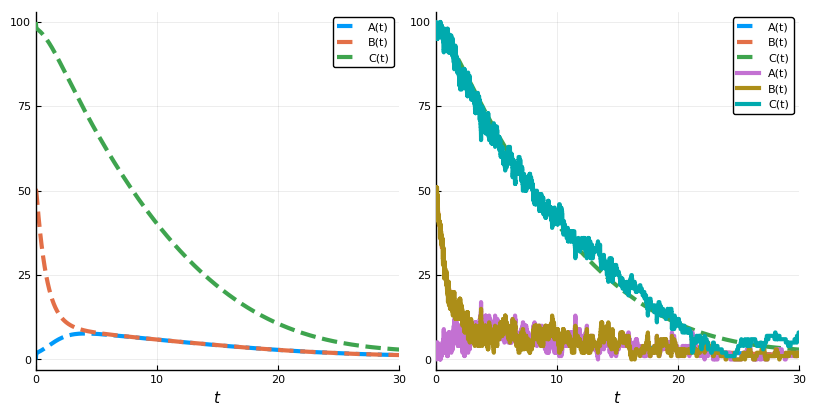

In [47]:
fmt = :pdf
p1 = plot(osol, fmt=fmt, linestyle=:dash, xlabel=L"t")
p2 = plot(osol, fmt=fmt, linestyle=:dash, xlabel=L"t")
plot!(p2, jsol, fmt=fmt, xlabel=L"t")
plot(p1,p2, size=(800,400))
fname = string(pwd(),"/abtoc.pdf")
savefig(fname)